In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd "/content/drive/My Drive/data"; ls -l

total 329893
-rw------- 1 root root 337809843 Feb 23 04:01 mercari_train.tsv


# 데이터 전처리

In [3]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv("/content/drive/My Drive/data/mercari_train.tsv", sep = "\t")
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


* train_id: 데이터 id
* name: 제품명
* item_condition_id: 판매자가 제공하는 제품 상태
* category_name: 카테고리 명
* brand_name: 브랜드 이름
* price: 제품 가격. 예측을 위한 타깃 속성
* shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
* item_description: 제품에 대한 설명

In [4]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


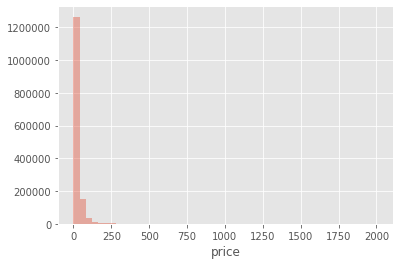

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")
y_train = mercari_df["price"]
plt.figure(figsize = (6, 4))
sns.distplot(y_train, kde = False)

# 타겟값 로그 변환 후 분포도 확인

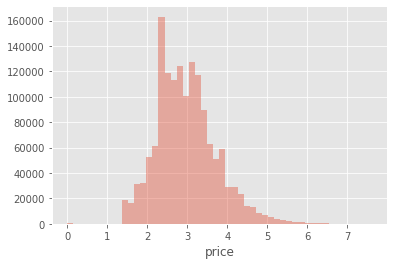

In [6]:
import numpy as np

y_train = np.log1p(y_train)
sns.distplot(y_train, kde = False)

In [7]:
mercari_df["price"] = np.log1p(mercari_df["price"])
mercari_df["price"].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [8]:
print("Shipping 값 유형 : \n", mercari_df["shipping"].value_counts())
print()
print("item_condition_id 값 유형 : \n", mercari_df["item_condition_id"].value_counts())

Shipping 값 유형 : 
 0    819435
1    663100
Name: shipping, dtype: int64

item_condition_id 값 유형 : 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [9]:
condition = mercari_df["item_description"] == "No description yet"
mercari_df[condition]["item_description"].count()

82489

In [10]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트 반환
def split_cat(category_name):
  try:
    return category_name.split("/")
  except:
    return ["Other_Null", "Other_Null", "Other_Null"]
  
# 위의 split_cat()을 apply lambda에서 호출 하여 대, 중, 소 컬럼을 mercari_df에 생성
mercari_df["cat_dae"], mercari_df["cat_jung"], mercari_df["cat_so"] = zip(*mercari_df["category_name"].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print("대분류 유형 : \n", mercari_df["cat_dae"].value_counts)
print("중분류 갯수 : ", mercari_df["cat_jung"].nunique())
print("소분류 갯수 : ", mercari_df["cat_so"].nunique())

대분류 유형 : 
 <bound method IndexOpsMixin.value_counts of 0                        Men
1                Electronics
2                      Women
3                       Home
4                      Women
                 ...        
1482530                Women
1482531                 Kids
1482532    Sports & Outdoors
1482533                 Home
1482534                Women
Name: cat_dae, Length: 1482535, dtype: object>
중분류 갯수 :  114
소분류 갯수 :  871


In [11]:
# 위의 split_cat()을 apply lambda에서 호출하여 대, 중, 소 컬럼을 mercar_df에 생성
mercari_df["category_list"] = mercari_df["category_name"].apply(lambda x : split_cat(x))
mercari_df["category_list"].head()

0                                [Men, Tops, T-shirts]
1    [Electronics, Computers & Tablets, Components ...
2                      [Women, Tops & Blouses, Blouse]
3               [Home, Home Décor, Home Décor Accents]
4                          [Women, Jewelry, Necklaces]
Name: category_list, dtype: object

In [12]:
mercari_df["cat_dae"] = mercari_df["category_list"].apply(lambda x : x[0])
mercari_df["cat_jung"] = mercari_df["category_list"].apply(lambda x : x[1])
mercari_df["cat_so"] = mercari_df["category_list"].apply(lambda x : x[2])
mercari_df[["cat_dae", "cat_jung", "cat_so"]].head()

,cat_dae,cat_jung,cat_so
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


In [0]:
mercari_df.drop("category_list", axis = 1, inplace=True)

In [0]:
mercari_df["brand_name"].fillna("Other_Null", inplace = True)
mercari_df["category_name"].fillna("Other_Null", inplace = True)
mercari_df["item_description"].fillna("Other_Null",inplace = True)

In [15]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1482535 non-null object
brand_name           1482535 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482535 non-null object
cat_dae              1482535 non-null object
cat_jung             1482535 non-null object
cat_so               1482535 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


In [16]:
print("brand name의 유형 건수 : ", mercari_df["brand_name"].nunique())
print("brand name sample 5건 : \n", mercari_df["brand_name"].value_counts()[:5])

brand name의 유형 건수 :  4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [17]:
print("name의 종류 갯수 : ", mercari_df["name"].nunique())
print("name sample 7건 : \n", mercari_df["name"][:7])

name의 종류 갯수 :  1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [18]:
pd.set_option("max_colwidth", 200)

# item_description의 평균 문자열 개수
print("item_description 평균 문자열 개수 : ", mercari_df["item_description"].str.len().mean())
mercari_df["item_description"][:2]

item_description 평균 문자열 개수 :  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [19]:
import gc
gc.collect()

11

# name은 Count, item_description은 TF-IDF로 피처 벡터화

In [20]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer(max_features=30000)
X_name = cnt_vec.fit_transform(mercari_df["name"])

# item_description에 대한 feature vectorization 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range = (1, 3), stop_words = "english")
X_descp = tfidf_descp.fit_transform(mercari_df["item_description"])

print("name vectorization shape : ", X_name.shape)
print("item_description vectorization shape : ", X_descp.shape)

name vectorization shape :  (1482535, 30000)
item_description vectorization shape :  (1482535, 50000)


In [0]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df["brand_name"])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df["item_condition_id"])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df["shipping"])

lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df["cat_dae"])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_dae.fit_transform(mercari_df["cat_jung"])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_dae.fit_transform(mercari_df["cat_so"])

In [22]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print("X_brand shape : {0}, X_item_cond_id shape : {1}".format(X_brand.shape, X_item_cond_id.shape))
print("X_shipping shape : {0}, X_cat_dae shape : {1}".format(X_shipping.shape, X_cat_dae.shape))
print("X_cat_jung shape : {0}, X_cat_so shape : {1}".format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape : (1482535, 4810), X_item_cond_id shape : (1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae shape : (1482535, 11)
X_cat_jung shape : (1482535, 114), X_cat_so shape : (1482535, 871)


In [23]:
import gc
gc.collect()

0

In [24]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터셋을 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


0

In [0]:
def rmsle(y, y_pred):
  return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y_pred))))

def evaluate_org_price(y_test, preds):
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [0]:
def model_train_predict(model, matrix_list):
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df["price"], test_size = 0.2, random_state = 156)

  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

In [27]:
linear_model = Ridge(solver="lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print("Item Description을 제외했을 때 rmsle 값 : ", evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print("Item Description을 포함한 rmlse 값 : ", evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값 :  0.5027973690574066
Item Description을 포함한 rmlse 값 :  0.47114366040632394


In [28]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(lgbm_model, matrix_list = sparse_matrix_list)
print("LightGBM rmlse 값 : ", evaluate_org_price(y_test, lgbm_preds))

LightGBM rmlse 값 :  0.4569096300487453


In [29]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print("LightGBM과 Ridge를 ensemble한 최종 rmsle 값 : ", evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값 :  0.45059234446789687
